In [85]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso

import scipy.stats
import cvxpy as cp

plt.rcParams.update({'font.size': 20})

# Figure 1: Double Ridge Illustration

### a simple numerical example, illustrating the regularization path for ridge

In [86]:
np.random.seed(50)

d = 10
n = 100

In [87]:
# for illustrative purposes, we draw source covariates Xp with a diagonal covariance matrix
orth = scipy.stats.special_ortho_group.rvs(n)
U, s, V = np.linalg.svd(orth)

# set the spectrum:
# we use a constant to make the plot simpler
# but it is enlightening to make this decline gradually
snew = s * 0.7
Xnew = U@np.diag(snew)

Xp = Xnew[:, :d]

In [88]:
# draw ys from linear model
beta_0 = np.random.normal(size=d)
yp = Xp @ beta_0 + np.random.normal(size=n)

In [89]:
# set a deterministic target covariate mean
Xqbar = np.ones(shape=d)
Xqbar[::3] *= -1
Xqbar *= np.arange(d)/4+0.5

In [90]:
Xqbar

array([-0.5 ,  0.75,  1.  , -1.25,  1.5 ,  1.75, -2.  ,  2.25,  2.5 ,
       -2.75])

## Ridge regularized outcome models

In [91]:
# fit the ols model
ols = LinearRegression(fit_intercept=False).fit(Xp, yp)
beta_ols = ols.coef_

In [92]:
# fit the regularized machine learning outcome model
outcome_hyperparam = 2
ridge = Ridge(alpha=outcome_hyperparam, fit_intercept=False).fit(Xp, yp)
beta_ridge = ridge.coef_

In [93]:
# now plot the regularized model in context of the whole regularization path
lambdas = np.linspace(0, 12, 2000)
beta_ridges = [Ridge(alpha=lam, fit_intercept=False).fit(Xp, yp).coef_ for lam in lambdas]

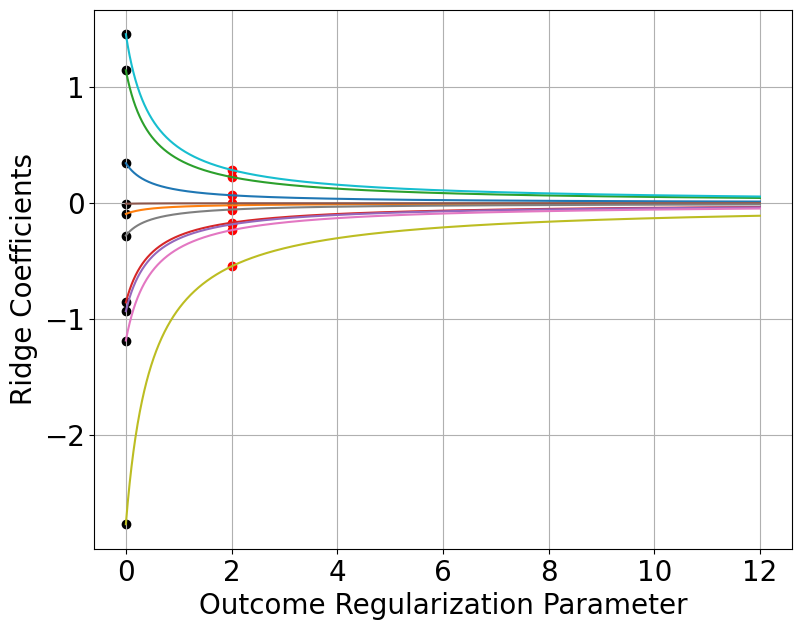

In [94]:
plt.figure(figsize=(9,7))
plt.plot(lambdas, beta_ridges)
plt.scatter(np.zeros(d),beta_ols, color='black')
plt.scatter([outcome_hyperparam]*d, beta_ridge, color='red')
plt.ylabel(" Ridge Coefficients ")
plt.xlabel("Outcome Regularization Parameter")
plt.grid()

In [95]:
# next compute the weights and beta aug for a range of
# values for the weight regularization parameter, delta

In [96]:
def get_ridge_weight_coefs(delta):
    return np.linalg.inv(Xp.T@ Xp + delta * np.eye(d)) @ Xqbar

In [97]:
deltas = np.linspace(0, 10, 1000)
all_beta_aug = []
all_xqhat = []
for delta in deltas:
    # now fit the weighting model
    theta = get_ridge_weight_coefs(delta)
    Xqhat = (Xp.T@ Xp) @ theta
    all_xqhat.append(Xqhat)
    a = Xqhat/Xqbar
    beta_aug = (1-a)*beta_ridge + a*beta_ols
    all_beta_aug.append(beta_aug)

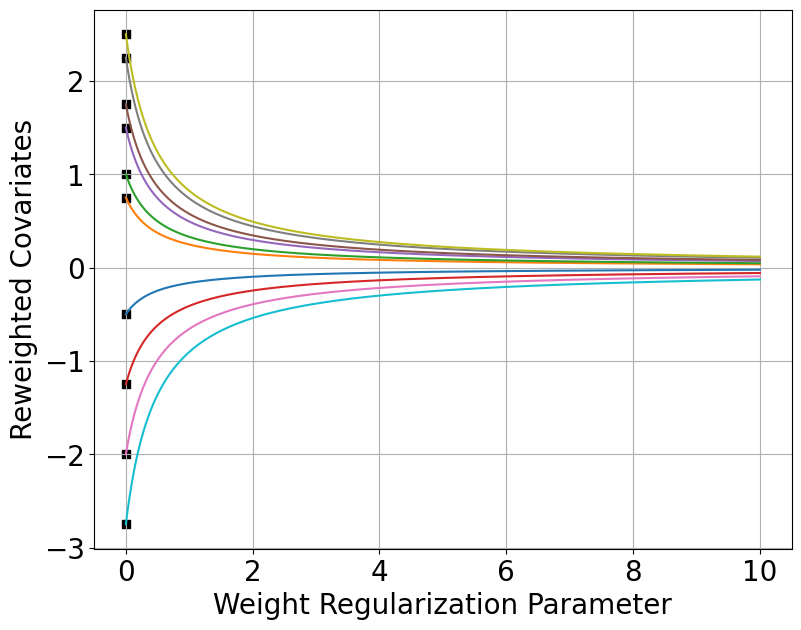

In [98]:
plt.figure(figsize=(9,7))
plt.plot(deltas, all_xqhat)
plt.scatter(np.zeros(d), Xqbar, color='black', marker='s')
plt.ylabel("Reweighted Covariates")
plt.xlabel("Weight Regularization Parameter")
plt.grid()

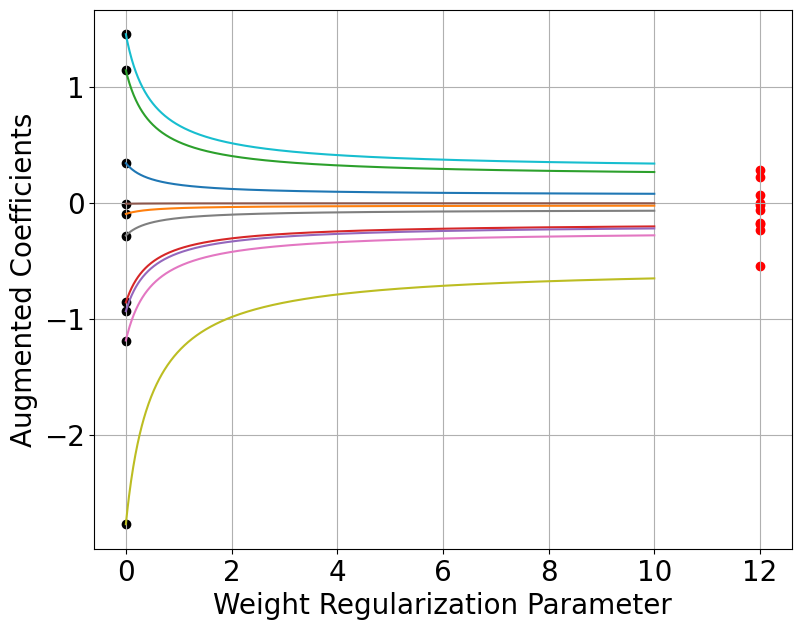

In [99]:
plt.figure(figsize=(9,7))
plt.plot(deltas, all_beta_aug);
plt.scatter(np.zeros(d),beta_ols, color='black')
plt.scatter([12]*d, beta_ridge, color='red')
plt.ylabel("Augmented Coefficients")
plt.xlabel("Weight Regularization Parameter")
plt.grid()

# Figure 2: Double Lasso Illustration

#### dgp is identical but now we use lasso models and weights

In [100]:
# fit the regularized machine learning outcome model
outcome_hyperparam = 0.005
lasso = Lasso(alpha=outcome_hyperparam, fit_intercept=False).fit(Xp, yp)
beta_lasso = lasso.coef_

In [101]:
# now plot the regularized model in context of the whole regularization path
lambdas = np.linspace(1e-6, 0.015, 2000)
beta_lassos = [Lasso(alpha=lam, fit_intercept=False).fit(Xp, yp).coef_ for lam in lambdas]

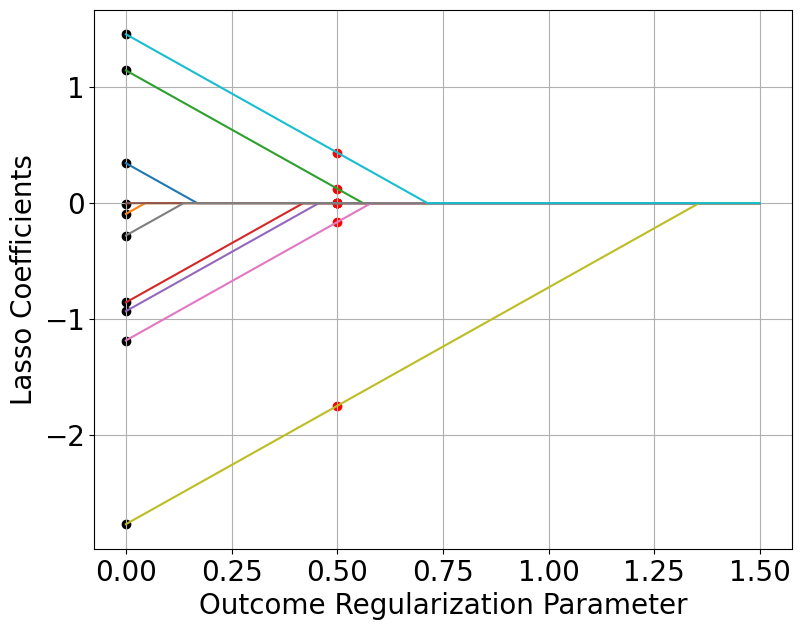

In [102]:
plt.figure(figsize=(9,7))
plt.plot(lambdas*n, beta_lassos)
plt.scatter(np.zeros(d),beta_ols, color='black')
plt.scatter([outcome_hyperparam*n]*d, beta_lasso, color='red')
plt.ylabel(" Lasso Coefficients ")
plt.xlabel("Outcome Regularization Parameter")
plt.grid()

In [115]:
def get_lasso_weights(delta):

    N=Xp.shape[0]
    M=Xp.shape[1]

    w = cp.Variable(N)

    prob = cp.Problem(cp.Minimize(cp.sum_squares(w)), [cp.norm( (w@Xp) - Xqbar , 'inf')<=delta])
    
    optimal_value = prob.solve(solver='ECOS')
    return(w.value)

In [116]:
deltas = np.linspace(0, 3, 100)
all_beta_aug = []
all_xqhat = []
for delta in deltas:
    # now fit the weighting model
    w = get_lasso_weights(delta)
    Xqhat = w @ Xp
    all_xqhat.append(Xqhat)
    a = Xqhat/Xqbar
    beta_aug = (1-a)*beta_lasso + a*beta_ols
    all_beta_aug.append(beta_aug)

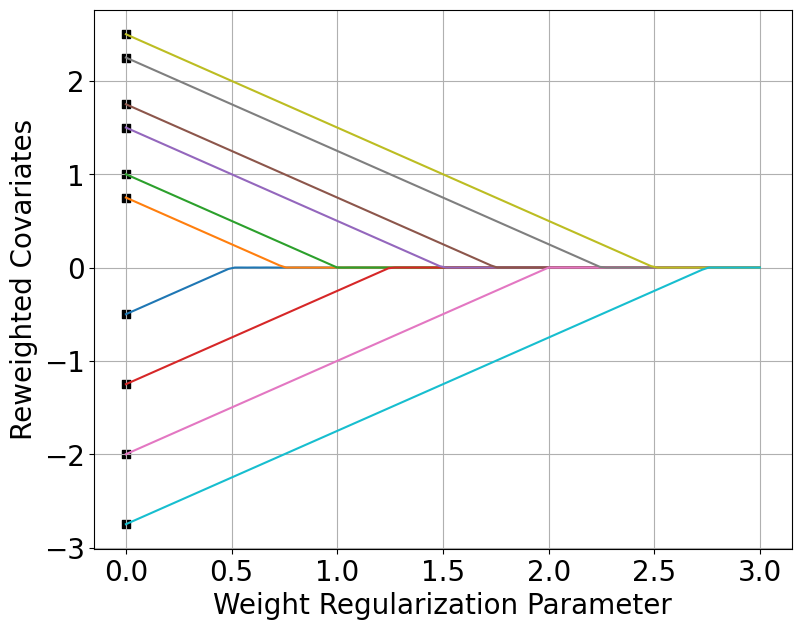

In [117]:
plt.figure(figsize=(9,7))
plt.plot(deltas, all_xqhat)
plt.scatter(np.zeros(d), Xqbar, color='black', marker='s')
plt.ylabel("Reweighted Covariates")
plt.xlabel("Weight Regularization Parameter")
plt.grid()

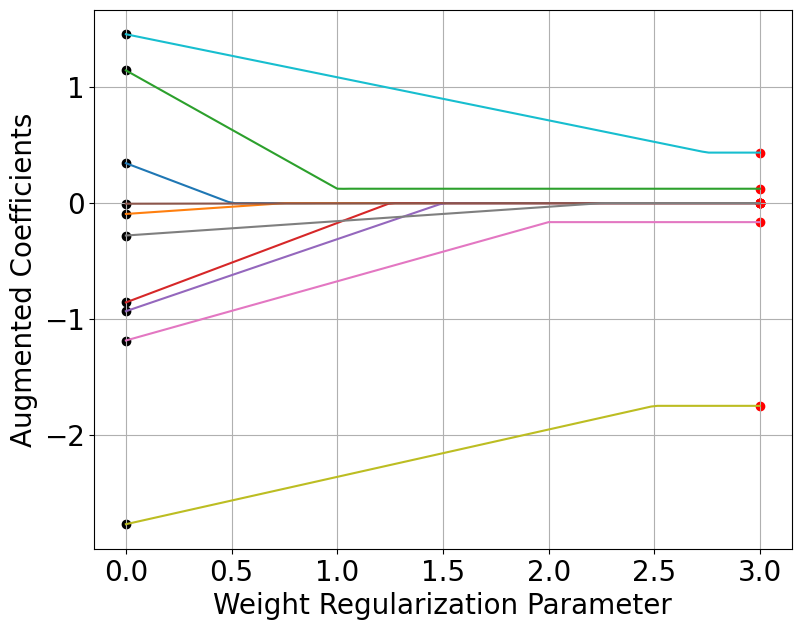

In [118]:
plt.figure(figsize=(9,7))
plt.plot(deltas, all_beta_aug);
plt.scatter(np.zeros(d),beta_ols, color='black')
plt.scatter([3]*d, beta_lasso, color='red')
plt.ylabel("Augmented Coefficients")
plt.xlabel("Weight Regularization Parameter")
plt.grid()